In [130]:
%matplotlib inline
 
# ライブラリのインポート
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from IPython.display import Image


In [131]:
# ハイパーパラメータの設定
EPOCHS = 5 # エポック数
BATCH_SIZE = 100 # バッチサイズ
LEARNING_RATE = 0.0005 # 学習率

In [133]:
# データセットの用意
# transformはデータセットに対する前処理を表す
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

# datasetsは実際のデータセットを表す
# ここではmnistを利用、手元にない場合は自動的にダウンロードする
# またtransformをここでセットする
# 学習データ用とテストデータ用を２つ用意する
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

# DataLoaderはデータセットをバッチサイズごとに利用するためのもの
# datasetsをここでセットする
# 学習データ用とテストデータ用を２つ用意する
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [132]:
# ネットワークアーキテクチャの構築
class Net(nn.Module):
    # ここで各層の名前を定義
    def __init__(self):
        super(Net, self).__init__()
        # 畳み込み層１
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32
        # 畳み込み層２
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        # プーリング層
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64
        # ドロップアウト層１
        self.dropout1 = nn.Dropout2d()
        # 全結合層１
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        # ドロップアウト層２
        self.dropout2 = nn.Dropout2d()
        # 全結合層２
        self.fc2 = nn.Linear(128, 10)

    # 層同士の接続を定義
    def forward(self, x):
        # 入力は28x28(画像サイズが28px*28pxなので)
        x = self.conv1(x)
        x = F.relu(x) # 活性化関数を挿入する（ここではReLU関数を使用）
        x = self.conv2(x)
        x = F.relu(x) # 活性化関数を挿入する（ここではReLU関数を使用）
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1, 12 * 12 * 64) #　ここで行列をベクトル化（全結合層に入力するため）
        x = self.fc1(x)
        x = F.relu(x) # 活性化関数を挿入する（ここではReLU関数を使用）
        x = self.dropout2(x)
        x = self.fc2(x)
        # 出力は10次元（10種類の数字なので）
        return x

In [134]:
net = Net() # ネットワークをインスタンス化
device = torch.device("cuda") # GPUの設定
net = net.to(device) # ネットワークをGPU上に展開
criterion = nn.CrossEntropyLoss() # 損失関数の設定（ここではクロスエントロピー誤差を使用）
# オプティマイザの設定（どのように重みの値を更新していくかを決める）
optimizer = optim.SGD(net.parameters(),
                      lr=LEARNING_RATE, momentum=0.99, nesterov=True)

In [135]:
# 実際に学習を進める
# ここのforは１回実行されるごとに１エポック分の学習が進む
for epoch in range(EPOCHS):
    print("+++ epoch {:d} +++".format(epoch))

    running_loss = 0.0
    # ここのforは１回実行されるごとに１バッチ分のデータで学習が進む
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 勾配をリセットする（Tensor型は勾配が蓄積してしまうため）
        outputs = net(inputs) # 順伝搬を行う
        # 順伝搬結果と正解ラベルを元に損失を計算する（正解ラベルとの誤差）
        loss = criterion(outputs, labels)
        loss.backward() # 誤差逆伝搬を行う
        optimizer.step() #　重みを更新

        # 表示用コード
        running_loss += loss.item()
        if i % 100 == 99:
            print("   iteration{:5d} ---> loss: {:.3f}"
                  .format(i+1, running_loss/100))
            running_loss = 0.0
    print("")
print('Finished Training')

+++ epoch 0 +++
   iteration  100 ---> loss: 2.191
   iteration  200 ---> loss: 1.074
   iteration  300 ---> loss: 0.566
   iteration  400 ---> loss: 0.452
   iteration  500 ---> loss: 0.384
   iteration  600 ---> loss: 0.350

+++ epoch 1 +++
   iteration  200 ---> loss: 0.267
   iteration  300 ---> loss: 0.237
   iteration  400 ---> loss: 0.218
   iteration  500 ---> loss: 0.200
   iteration  600 ---> loss: 0.196

+++ epoch 2 +++
   iteration  100 ---> loss: 0.181
   iteration  200 ---> loss: 0.168
   iteration  300 ---> loss: 0.157
   iteration  400 ---> loss: 0.159
   iteration  500 ---> loss: 0.155
   iteration  600 ---> loss: 0.145

+++ epoch 3 +++
   iteration  100 ---> loss: 0.132
   iteration  200 ---> loss: 0.139
   iteration  300 ---> loss: 0.132
   iteration  400 ---> loss: 0.123
   iteration  500 ---> loss: 0.125
   iteration  600 ---> loss: 0.114

+++ epoch 4 +++
   iteration  100 ---> loss: 0.114
   iteration  200 ---> loss: 0.113
   iteration  300 ---> loss: 0.106
   ite

Predicted Label :  8
GT Label :  9


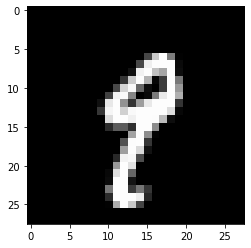

In [140]:
# 推論結果例を表示
index = random.randint(0, 99) # ランダムに０から９９までの整数を取得
test_iter = iter(testloader)
inputs, labels = test_iter.next() # テストデータから１バッチ分のデータを取得
inputs = inputs.to(device) # テストデータをGPUに展開
outputs = net(inputs) # 推論を行う（順伝搬）
_, predicted = torch.max(outputs.data, 1) # 推論結果から正解クラス（数字）を出力
# 画像を表示
plt.imshow(inputs[index].to('cpu').detach().numpy().copy().reshape(28, 28), cmap='gray')
print("Predicted Label : ", predicted[index].item())
print("GT Label : ", labels[index].item())
